### Import libraries

In [24]:
import os

import torch
from torch.utils.data import DataLoader, Subset

import seaborn as sns

import numpy as np
np.random.seed(42)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from umap import UMAP

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')

### Get some embeddings

In [60]:
embeddings_img = torch.Tensor()
embeddings_sig = torch.Tensor()

step = 1100
for n in range(24):
    embeddings_b_img = torch.load(f"/vol/aimspace/users/tuo/ECGMultimodalContrastiveLearning/runs/multimodal/version_1000/embeddings/embeddings_imaging_step{step}_batch{n}.pt")
    embeddings_b_sig = torch.load(f"/vol/aimspace/users/tuo/ECGMultimodalContrastiveLearning/runs/multimodal/version_1000/embeddings/embeddings_signal_step{step}_batch{n}.pt")

    embeddings_img = torch.cat((embeddings_img, embeddings_b_img), dim=0)
    embeddings_sig = torch.cat((embeddings_sig, embeddings_b_sig), dim=0)

print(embeddings_img.shape, embeddings_sig.shape)

torch.Size([6007, 128]) torch.Size([6007, 128])


In [3]:
labels = np.zeros((6007, ))
for idx, disease in enumerate(['CAD', 'diabetes', 'flutter']):
    label_dis = torch.load(f"/vol/aimspace/projects/ukbb/cardiac/cardiac_segmentations/projects/ecg/labels_val_{disease}_all.pt")
    label_dis = np.array(label_dis)*(idx+1)
    labels = labels + label_dis
    print(np.unique(label_dis, return_counts=True))

print(np.unique(labels, return_counts=True))

(array([0, 1]), array([5574,  433]))
(array([0, 2]), array([5762,  245]))
(array([0, 3]), array([5839,  168]))
(array([0., 1., 2., 3., 4., 5., 6.]), array([5284,  335,  175,  146,   42,   14,   11]))


In [4]:
labels.shape

(6007,)

In [5]:
embeddings_img.shape, np.array(labels).shape

(torch.Size([6007, 128]), (6007,))

In [7]:
embeddings = embeddings_img

In [67]:
# embeddings = torch.cat((embeddings_img, embeddings_sig), dim=0)
# labels = list(np.zeros(6007)) + list(np.ones(6007))

### Visualize the embeddings with t-SNE

In [61]:
tsne = TSNE(n_components=3, learning_rate='auto', init='random', verbose=0)
tsne_proj = tsne.fit_transform(embeddings)

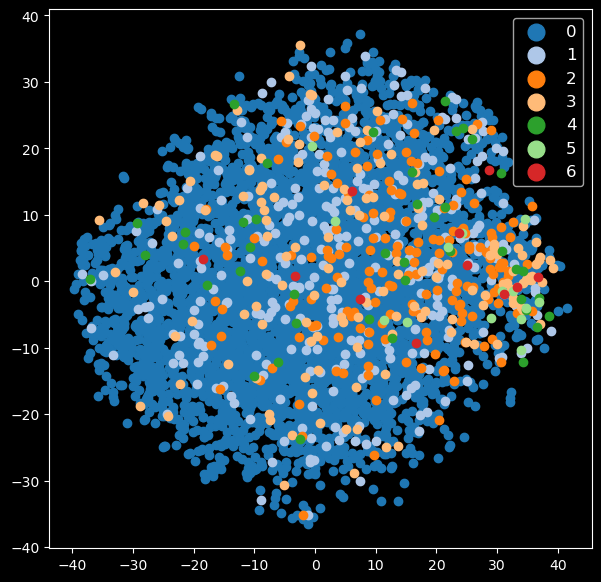

In [62]:
# 2D
cmap = sns.color_palette("tab20", as_cmap=True)
fig, ax = plt.subplots(figsize=(7, 7))

nb_classes = 7
for label in range(nb_classes):
    indices = np.array(labels)==label
    indices = indices[-embeddings.shape[0]:]
    ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], c=np.array(cmap(label)).reshape(1, 4), label=label, alpha=1)

ax.legend(fontsize='large', markerscale=2)
plt.show()

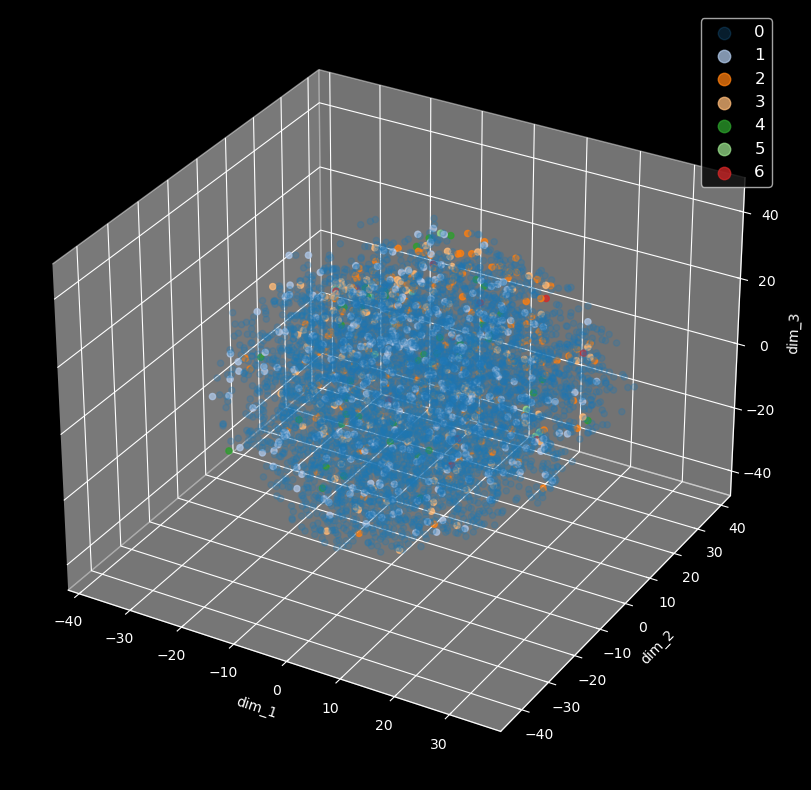

In [22]:
# 3D
cmap = matplotlib.cm.get_cmap('tab20') # for the colours

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

nb_classes = 7
for label in range(nb_classes):
    if label == 0:
        alpha = 0.25
    else:
        alpha = 0.75
    indices = np.array(labels)==label
    indices = indices[-embeddings.shape[0]:]
    ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 2], tsne_proj[indices, 1], c=np.array(cmap(label)).reshape(1, 4), label=label, alpha=alpha)

ax.set_xlabel("dim_1")
ax.set_ylabel("dim_2")
ax.set_zlabel("dim_3")

ax.legend(fontsize='large', markerscale=2)
plt.show()

### Visualize the embeddings with PCA

How much information do the embeddings contain?

[0.06983734 0.06405501 0.05976379 0.05565528 0.05403856 0.04974225
 0.04778533 0.04579946 0.04343933 0.04043434 0.04021597 0.0361356
 0.0348093  0.03209458 0.03183286 0.02875069 0.02759465 0.02592919
 0.02505465 0.02257552 0.02207776 0.01873089 0.0171478  0.01428747]
0.09221236737406857


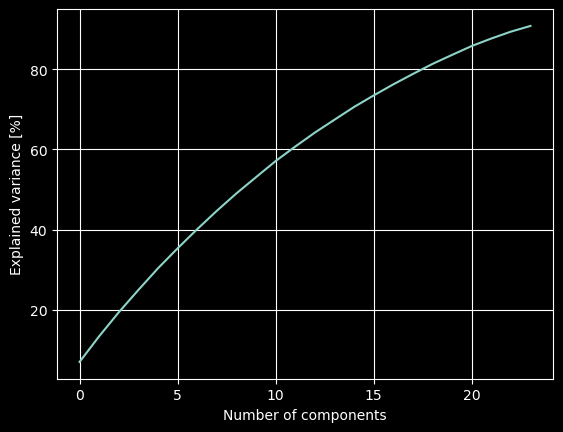

In [48]:
pca = PCA(n_components=0.9)
pca_proj = pca.fit_transform(embeddings)

print(pca.explained_variance_ratio_)
print(1-pca.explained_variance_ratio_.sum())

plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance [%]')
plt.show()

In [49]:
pca = PCA(n_components=3)
pca_proj = pca.fit_transform(embeddings)

print(pca.explained_variance_ratio_)
print(1-pca.explained_variance_ratio_.sum())

[0.06983726 0.06405413 0.05975774]
0.806350876509457


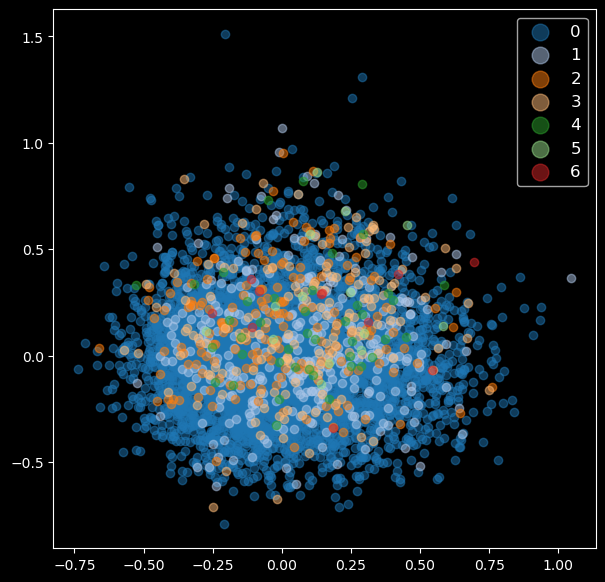

In [50]:
# 2D
cmap = matplotlib.cm.get_cmap('tab20') # for the colours

fig, ax = plt.subplots(figsize=(7, 7))

nb_classes = 7
for label in range(nb_classes):
    indices = np.array(labels)==label
    indices = indices[-embeddings.shape[0]:]
    ax.scatter(pca_proj[indices, 0], pca_proj[indices, 1], c=np.array(cmap(label)).reshape(1, 4), label=label, alpha=0.5)

ax.legend(fontsize='large', markerscale=2)
plt.show()

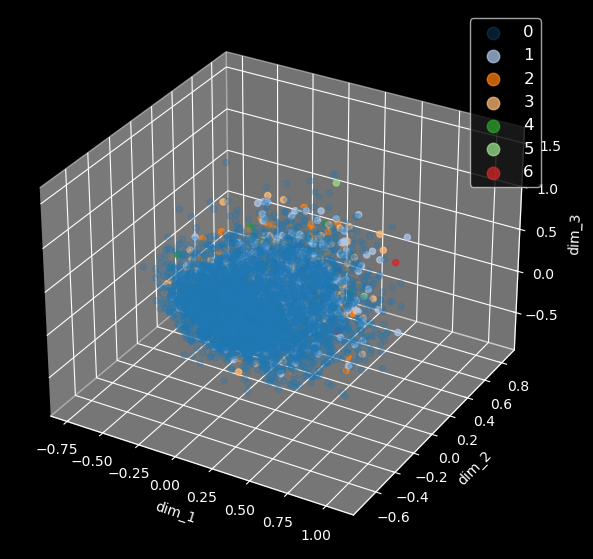

In [55]:
# 3D
cmap = matplotlib.cm.get_cmap('tab20') # for the colours

fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111, projection='3d')

nb_classes = 7
for label in range(nb_classes):
    if label == 0:
        alpha = 0.25
    else:
        alpha = 0.75
    indices = np.array(labels)==label
    indices = indices[-embeddings.shape[0]:]
    ax.scatter(pca_proj[indices, 0], pca_proj[indices, 2], pca_proj[indices, 1], c=np.array(cmap(label)).reshape(1, 4), label=label, alpha=alpha)

ax.set_xlabel("dim_1")
ax.set_ylabel("dim_2")
ax.set_zlabel("dim_3")

ax.legend(fontsize='large', markerscale=2)
plt.show()

### Visualize the embeddings with UMAP

In [56]:
umap = UMAP(n_components=3, metric='euclidean')
umap_proj = umap.fit_transform(embeddings)

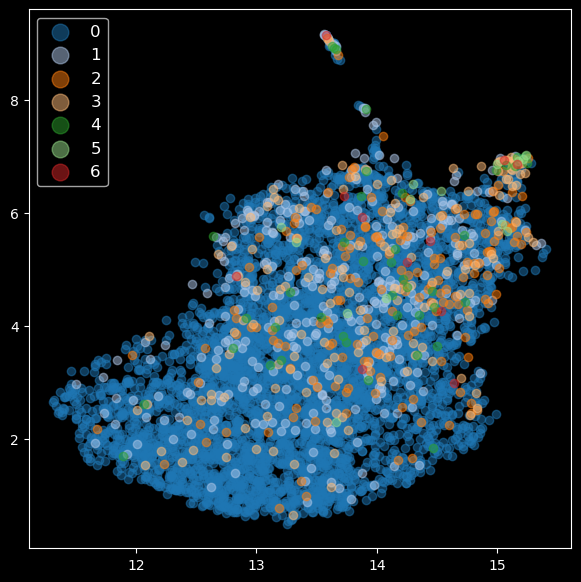

In [57]:
# 2D
cmap = matplotlib.cm.get_cmap('tab20') # for the colours

fig, ax = plt.subplots(figsize=(7, 7))

nb_classes = 7
for label in range(nb_classes):
    indices = np.array(labels)==label
    indices = indices[-embeddings.shape[0]:]
    ax.scatter(umap_proj[indices, 0], umap_proj[indices, 1], c=np.array(cmap(label)).reshape(1, 4), label=label, alpha=0.5)

ax.legend(fontsize='large', markerscale=2)
plt.show()

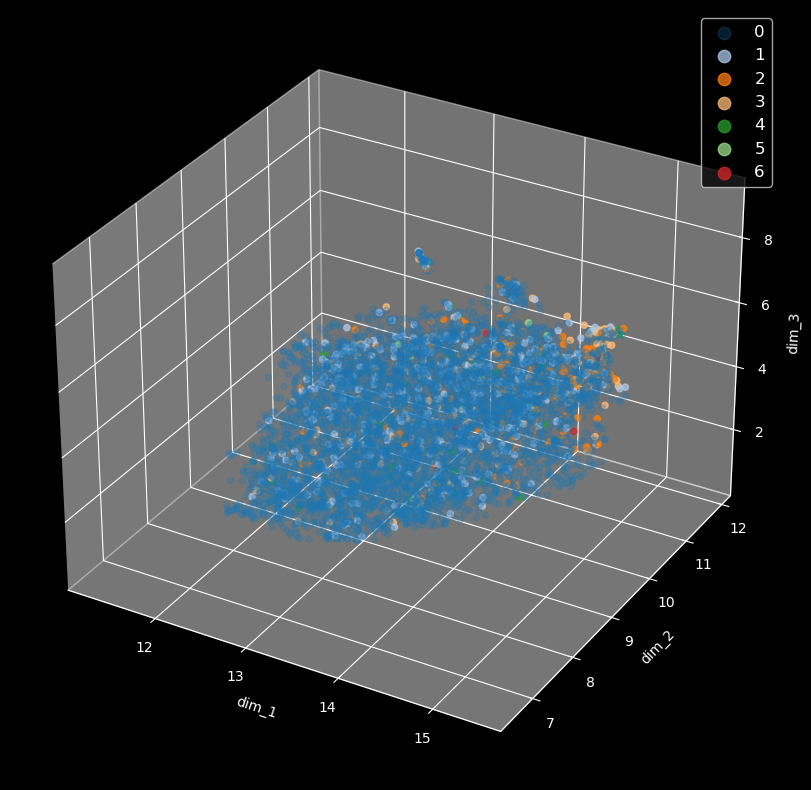

In [58]:
# 3D
cmap = matplotlib.cm.get_cmap('tab20') # for the colours

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

nb_classes = 7
for label in range(nb_classes):
    if label == 0:
        alpha = 0.25
    else:
        alpha = 0.75
    indices = np.array(labels)==label
    indices = indices[-embeddings.shape[0]:]
    ax.scatter(umap_proj[indices, 0], umap_proj[indices, 2], umap_proj[indices, 1], c=np.array(cmap(label)).reshape(1, 4), label=label, alpha=alpha)

ax.set_xlabel("dim_1")
ax.set_ylabel("dim_2")
ax.set_zlabel("dim_3")

ax.legend(fontsize='large', markerscale=2)
plt.show()